# Notebook for plotting the main shapes along the data workflow
### Jupyter notebook need to be improved
The considered shapes to be plotted refer to the output of the following scripts:
- build_shapes
- download_osm_data
- clean_osm_data
- build_osm_network
- base_network
- build_bus_regions

## Load packages

In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from shapely.geometry import LineString, Point
from shapely.wkt import loads
from collections import Counter

import os
import sys

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 2 folder(s) up.


## Build shapes

Load build_shapes output and plot them

In [2]:
# load shapes
continent = gpd.read_file("pypsa-earth/resources/shapes/country_shapes.geojson")
off_shore = gpd.read_file("pypsa-earth/resources/shapes/offshore_shapes.geojson")
gadm_shapes = gpd.read_file("pypsa-earth/resources/shapes/gadm_shapes.geojson")

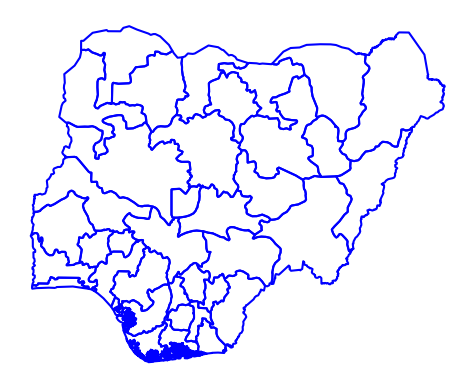

In [3]:
ax = gadm_shapes.boundary.plot(color="blue")
# off_shore.boundary.plot(ax=ax, color="green")
# continent.boundary.plot(ax=ax, color="red")
plt.axis("off")
plt.savefig("documentation/shapes_NG.png")

## download_osm_data

Load and plot the raw data downloaded by the power extractor package

<AxesSubplot:>

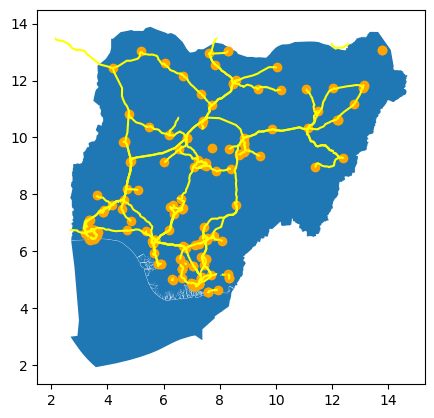

In [4]:
# plot output download_osm_data
df_substations_osm_download = gpd.read_file(
    os.getcwd() + "/pypsa-earth/resources/osm/raw/africa_all_raw_substations.geojson"
)
df_lines_osm_download = gpd.read_file(
    os.getcwd() + "/pypsa-earth/resources/osm/raw/africa_all_raw_lines.geojson"
)

ax = continent.plot(figsize=(5, 5))
off_shore.plot(ax=ax)
df_substations_osm_download.plot(ax=ax, color="orange")
df_lines_osm_download.plot(ax=ax, color="yellow")
# df_lines_osm_download[df_lines_osm_download.Country == "TD"].plot(ax=ax, color="yellow")
# plt.axis("off")
# plt.savefig("network.png")

In [5]:
# df_lines_osm_download[df_lines_osm_download.Country == "TD"]#.geometry.boundary#.dropna(subset=["tags.voltage"])

In [6]:
# analyses buses

cnt_buses = Counter(df_substations_osm_download["tags.voltage"])

cnt_buses_outliers = {
    key: value
    for (key, value) in cnt_buses.items()
    if key is None or not key.isnumeric()
}

cnt_buses_outliers

# sum(list(cnt_buses.values()))

{None: 119, '330000;132000': 20}

In [7]:
# analyses lines

cnt_lines = Counter(df_lines_osm_download["tags.voltage"])

cnt_lines_outliers = {
    key: value
    for (key, value) in cnt_lines.items()
    if key is None or not key.isnumeric()
}

cnt_lines_outliers

{None: 139, '330000;132000': 3}

## clean_osm_data

Load and plot the data filtered by the clean_osm_data script

<AxesSubplot:>

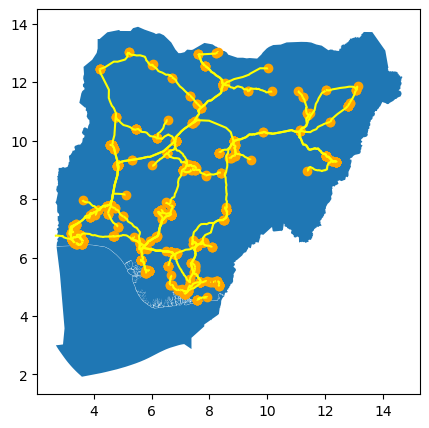

In [8]:
# plot output clean_osm_data
df_substations_osm_clean = gpd.read_file(
    os.getcwd() + "/pypsa-earth/resources/osm/clean/africa_all_substations.geojson"
)
df_lines_osm_clean = gpd.read_file(os.getcwd() + "/pypsa-earth/resources/osm/clean/africa_all_lines.geojson")

ax = continent.plot(figsize=(5, 5))
off_shore.plot(ax=ax)
df_substations_osm_clean.plot(ax=ax, color="orange")
df_lines_osm_clean.plot(ax=ax, color="yellow")

## build_osm_network

Load and plot the data of the network constructed by the build_osm_network script

<AxesSubplot:>

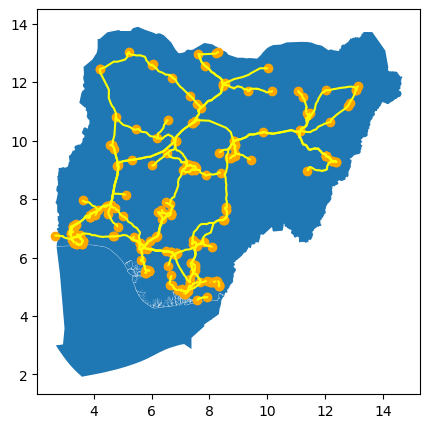

In [9]:
# plot output build_osm_network
df_substations_osm_build_network_pd = pd.read_csv(
    os.getcwd() + "/pypsa-earth/resources/base_network/africa_all_buses_build_network.csv"
)
df_lines_osm_build_network_pd = pd.read_csv(
    os.getcwd() + "/pypsa-earth/resources/base_network/africa_all_lines_build_network.csv"
)

df_substations_osm_build_network_pd["geometry"] = gpd.points_from_xy(
    df_substations_osm_build_network_pd.lon, df_substations_osm_build_network_pd.lat
)
# df_lines_osm_build_network_pd.dropna(subset="geometry", inplace=True)
df_lines_osm_build_network_pd["geometry"] = df_lines_osm_build_network_pd[
    "geometry"
].map(loads)

# df_substations_osm_build_network_pd = df_substations_osm_build_network_pd[df_substations_osm_build_network_pd.country=="EH"]
# df_lines_osm_build_network_pd = df_lines_osm_build_network_pd[df_lines_osm_build_network_pd.country=="EH"]

df_substations_osm_build_network = gpd.GeoDataFrame(
    geometry=df_substations_osm_build_network_pd.geometry, crs="epsg:4326"
)
df_lines_osm_build_network = gpd.GeoDataFrame(
    geometry=df_lines_osm_build_network_pd.geometry, crs="epsg:4326"
)

ax = continent.plot(figsize=(5, 5))
off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="orange")
df_lines_osm_build_network.plot(ax=ax, color="yellow")

In [10]:
df_substations_osm_build_network_pd[
    np.abs(df_substations_osm_build_network_pd["lat"] - 7.4710) < 0.001
]

,Unnamed: 0,bus_id,station_id,voltage,dc,symbol,under_construction,tag_substation,tag_area,lon,lat,country,geometry,substation_lv
98,98,98,80,132000,False,substation,False,transmission,0.0,6.6553,7.4711,NG,POINT (6.65530 7.47110),True


In [11]:
df_lines_osm_build_network_pd[
    (np.abs(df_lines_osm_build_network_pd.bus0_lat - 7.471) < 0.01)
    | (np.abs(df_lines_osm_build_network_pd.bus1_lon - 7.471))
].head(2)

,Unnamed: 0,line_id,bus0,bus1,voltage,circuits,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat
0,0,564729320-1_0,0,201,132000,1,5010.444841,False,False,line,50,NG,"LINESTRING (6.6507 5.0669, 6.650698800000018 5...","MULTIPOINT (6.6507 5.0669, 6.6913 5.0619)",POINT (6.6507 5.0669),POINT (6.6913 5.0619),6.6507,5.0669,6.6913,5.0619
1,1,546624332-1_0,2,195,330000,2,6434.654385,False,False,line,50,NG,"LINESTRING (5.6353 6.2973, 5.6360829 6.2959648...","MULTIPOINT (5.6353 6.2973, 5.679 6.3064)",POINT (5.6353 6.2973),POINT (5.679 6.3064),5.6353,6.2973,5.6790,6.3064


In [12]:
df_lines_osm_build_network_pd[
    (df_lines_osm_build_network_pd.bus0 == 97)
    | (df_lines_osm_build_network_pd.bus1 == 97)
]

,Unnamed: 0,line_id,bus0,bus1,voltage,circuits,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat
65,65,669957214-1_0,97,5,132000,2,10745.924978,False,False,line,50,NG,"LINESTRING (3.551 6.629, 3.551038199999974 6.6...","MULTIPOINT (3.551 6.629, 3.615 6.566)",POINT (3.551 6.629),POINT (3.615 6.566),3.551,6.629,3.615,6.566


In [ ]:
import hvplot.pandas

Substations__and_lines = df_substations_osm_build_network.hvplot(
    geo=True,
    size=10,  # buses["tag_area"]**(0.5)/10,
    frame_height=750,
    alpha=0.4,
    tiles="CartoLight",
    hover_cols=["bus_id"],
    color="orange",
) * df_lines_osm_build_network.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
    active_tools=["pan", "wheel_zoom"]
);
hvplot.save(Substations__and_lines, "documentation/Substations_and_lines.html");

In [14]:
df_substations_osm_build_network_pd.head(2)

,Unnamed: 0,bus_id,station_id,voltage,dc,symbol,under_construction,tag_substation,tag_area,lon,lat,country,geometry,substation_lv
0,0,0,0,132000,False,substation,False,transmission,0.0,6.6507,5.0669,NG,POINT (6.65070 5.06690),True
1,1,1,1,132000,False,substation,False,transmission,0.0,5.6343,6.2963,NG,POINT (5.63430 6.29630),True


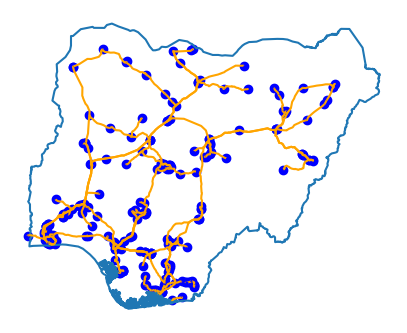

In [15]:
ax = continent.boundary.plot(figsize=(5, 5))
# off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="blue")
df_lines_osm_build_network.plot(ax=ax, color="orange")
plt.axis("off")
plt.savefig("documentation/map.png")

In [16]:
df_lines_osm_build_network_pd[
    df_lines_osm_build_network_pd.country == "NG"
].head(2) # .geometry.boundary#.dropna(subset=["tags.voltage"])
# df_lines_osm_build_network_pd[df_lines_osm_build_network_pd.line_id == "452716570-1"].copy().iloc[0]
# .geometry[0].bounds
# .boundary#.iloc[7402]

,Unnamed: 0,line_id,bus0,bus1,voltage,circuits,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat
0,0,564729320-1_0,0,201,132000,1,5010.444841,False,False,line,50,NG,"LINESTRING (6.6507 5.0669, 6.650698800000018 5...","MULTIPOINT (6.6507 5.0669, 6.6913 5.0619)",POINT (6.6507 5.0669),POINT (6.6913 5.0619),6.6507,5.0669,6.6913,5.0619
1,1,546624332-1_0,2,195,330000,2,6434.654385,False,False,line,50,NG,"LINESTRING (5.6353 6.2973, 5.6360829 6.2959648...","MULTIPOINT (5.6353 6.2973, 5.679 6.3064)",POINT (5.6353 6.2973),POINT (5.679 6.3064),5.6353,6.2973,5.6790,6.3064


## base_network

Load and plot the data of the network model implemented in PyPSA by the base_network script

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


<AxesSubplot:>

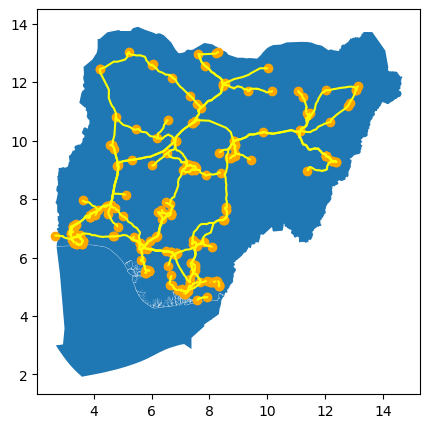

In [17]:
# plot output base_network
n = pypsa.Network(os.getcwd() + "/pypsa-earth/networks/base.nc")

lines_raw = n.lines.copy()
lines_raw["geometry"] = lines_raw["geometry"].map(loads)
# [LineString([Point(x.bus0_lon, x.bus0_lat), Point(x.bus1_lon, x.bus1_lat)]) for index, x in lines_raw.iterrows()
#     if (x.bus0_lat is not None) and (x.bus0_lon is not None) and (x.bus1_lat is not None) and (x.bus1_lon is not None)]
lines = gpd.GeoDataFrame(geometry=lines_raw.geometry, crs="epsg:4326")

buses_raw = n.buses.copy()
buses_raw["geometry"] = gpd.points_from_xy(buses_raw.lon, buses_raw.lat)
buses = gpd.GeoDataFrame(geometry=buses_raw.geometry, crs="epsg:4326")

continent = gpd.read_file("pypsa-earth/resources/shapes/country_shapes.geojson")
off_shore = gpd.read_file("pypsa-earth/resources/shapes/offshore_shapes.geojson")

ax = continent.plot(figsize=(5, 5))
off_shore.plot(ax=ax)
buses.plot(ax=ax, color="orange")
lines.plot(ax=ax, color="yellow")

In [18]:
lines_raw[
    lines_raw.country == "NG"
].head(2) # .geometry.boundary#.dropna(subset=["tags.voltage"])

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
564729320-1_0,0,201,220.0,1.0,5.010445,False,False,line,50,NG,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546624332-1_0,2,195,300.0,2.0,6.434654,False,False,line,50,NG,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## build_bus_regions

Plot the shapes obtained with the build_bus_regions script

ERROR:fiona._env:PROJ: proj_create_from_database: /home/anas/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_create_from_database: /home/anas/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


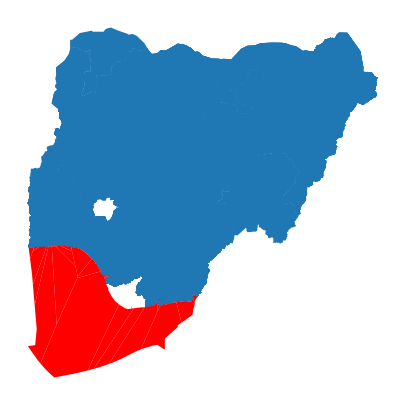

In [19]:
# plot output build_bus_regions

bus_regions_continent = gpd.read_file("pypsa-earth/resources/bus_regions/regions_onshore.geojson")
bus_regions_off_shore = gpd.read_file("pypsa-earth/resources/bus_regions/regions_offshore.geojson")

ax = bus_regions_continent.plot(figsize=(5, 5))
# bus_regions_continent[bus_regions_continent.country.map(lambda x: x in ["TD", "SS", "CF", "SO"])].plot(ax=ax, color="green")
bus_regions_off_shore.plot(ax=ax, color="red")
plt.axis("off")
plt.savefig("documentation/bus_regions.png")

<AxesSubplot:>

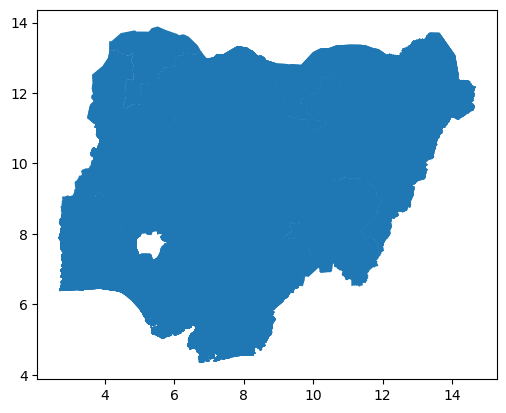

In [20]:
bus_regions_continent[bus_regions_continent.country == "NG"].plot()